#**Website Traffic Forecasting Using LSTM**

In this project, we developed a machine learning model to forecast website traffic using historical visitor data. The dataset consisted of daily visit counts, which were cleaned, normalized, and transformed into supervised learning sequences using a sliding window approach. We used a Long Short-Term Memory (LSTM) neural network due to its ability to capture temporal patterns in time series data. The model architecture included one LSTM layer with 128 units, followed by dense layers to produce a single traffic prediction. We trained the model over 200 epochs, with validation and model checkpointing to preserve the best-performing version. After training, we made predictions on unseen data and visualized the results by comparing the actual vs predicted traffic trends. The project demonstrated the effectiveness of LSTM in modeling sequential website traffic and provided valuable insights into user behavior for better planning and resource allocation.

In [1]:
!pip install tensorflow

pandas & numpy: For data handling and numerical operations.

matplotlib: For plotting graphs to visualize traffic data and predictions.

StandardScaler: To normalize inputs so the LSTM model can train effectively.

Sequential, LSTM, Dense: Used to define and build the neural network.

ModelCheckpoint: To save the best model during training.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint

Loads the dataset from CSV.

Converts the Date column to datetime.

Cleans data by dropping rows with invalid/missing dates or visits.

Normalizes the Visits by dividing by 1000 to make it easier for the model to train.



In [4]:
df = pd.read_csv("/content/traffic.csv")

In [5]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date', 'Visits'])

In [6]:
df['Visits'] = df['Visits'] / 1_000

In [7]:
visits = df['Visits'].values

First plot: Entire timeline of traffic.


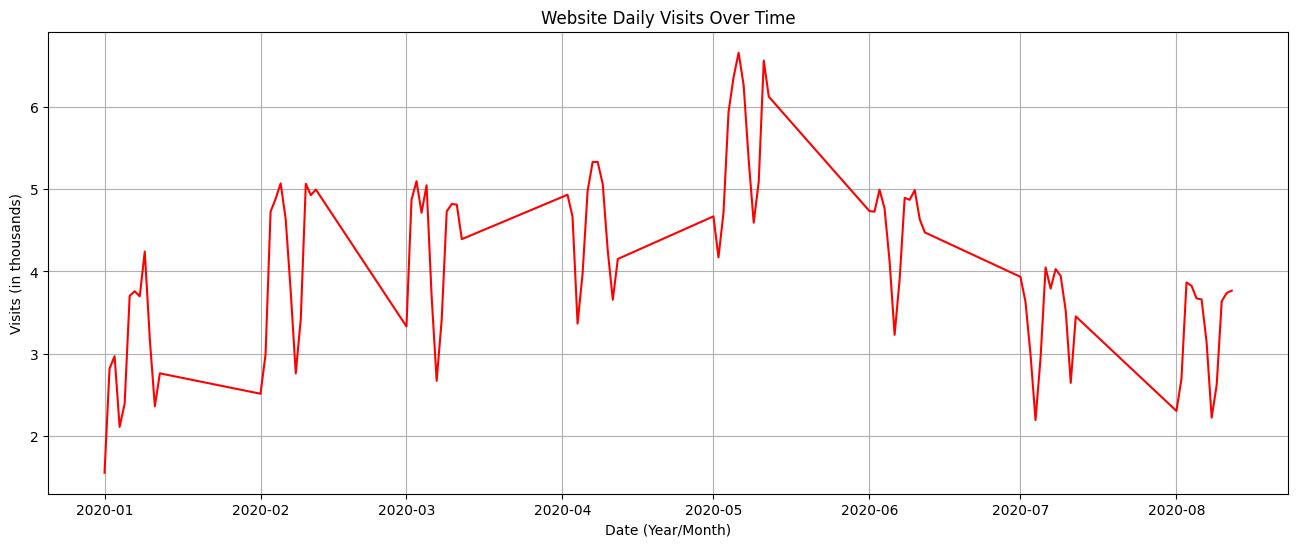

In [8]:
plt.figure(figsize=(16, 6))
plt.plot(df['Date'], visits, color='red')
plt.title("Website Daily Visits Over Time")
plt.xlabel("Date (Year/Month)")
plt.ylabel("Visits (in thousands)")
plt.grid(True)
plt.show()


Second plot: Zooms in on the first 7 days to show detailed daily fluctuation.

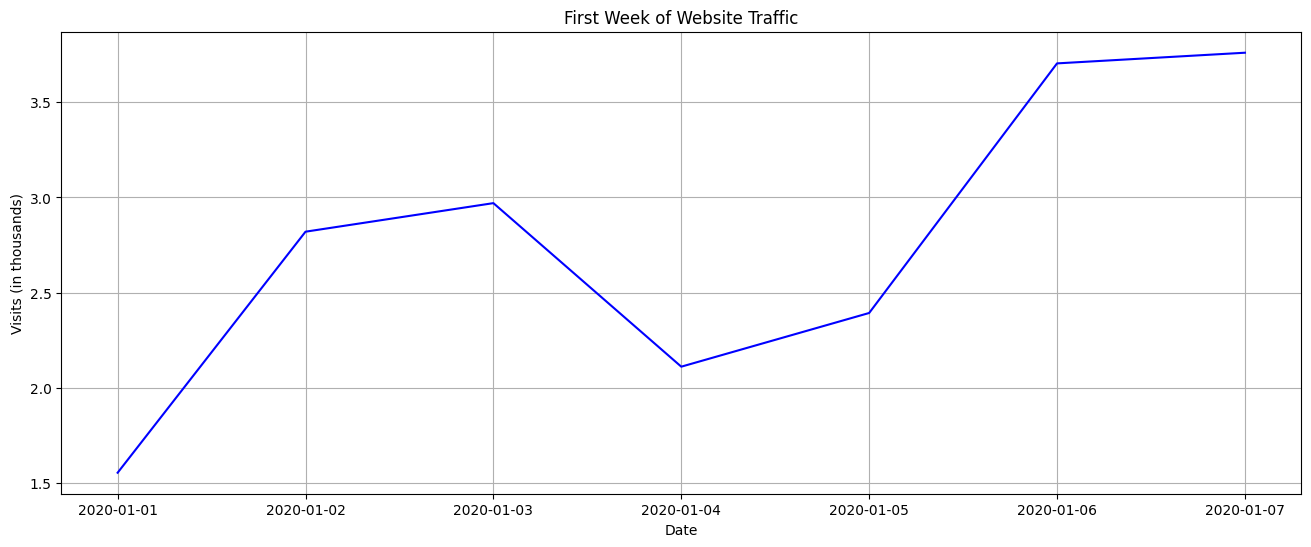

In [10]:
plt.figure(figsize=(16, 6))
plt.plot(df['Date'][:7], visits[:7], color='blue')
plt.title("First Week of Website Traffic")
plt.xlabel("Date")
plt.ylabel("Visits (in thousands)")
plt.grid(True)
plt.show()

Create Supervised Learning Dataset

Convert time series data into input-output pairs
LSTM models learn from sequences. This function turns the continuous traffic data into sliding windows of length n_steps (7 days).

Example:
X = [Day1, Day2, ..., Day7] → y = Day8



In [11]:
def prepare_data(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence) - n_steps):
        X.append(sequence[i:i+n_steps])
        y.append(sequence[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 7
X, y = prepare_data(visits, n_steps)

Train/Validation Split & Normalization

Split the data into 90% training and 10% validation.

Standardize (normalize) the values to have a mean of 0 and standard deviation of 1 for stable training.

In [12]:
split = int(len(X) * 0.9)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]

In [13]:
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
X_val = x_scaler.transform(X_val)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val = y_scaler.transform(y_val.reshape(-1, 1)).ravel()

Reshape Data for LSTM

Make data LSTM-compatible

LSTM needs 3D input: [samples, timesteps, features]

You're reshaping each 7-day sequence into the proper shape.

In [14]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

Build the LSTM Model

Define the LSTM neural network
LSTM(128): Remembers temporal patterns in 7-day sequences.

Dense(64): A fully connected layer to process learned features.

Dense(1): Outputs one prediction (next day’s traffic).

loss='mse': Minimizes mean squared error between predicted & actual traffic.

In [15]:
model = Sequential()
model.add(LSTM(128, input_shape=(n_steps, 1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,881 (292.50 KB)

 Trainable params: 74,881 (292.50 KB)

 Non-trainable params: 0 (0.00 B)

Save the Best Model: Save the model with the lowest validation loss. Prevents overfitting and ensures you use the best-performing version.

Train the LSTM model
epochs=200: Number of full training cycles.

batch_size=32: How many samples per weight update.

Validation loss is monitored to save the best model.

In [30]:
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, mode="min", verbose=1)
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint]
)

Epoch 1/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2933
Epoch 1: val_loss improved from inf to 0.11087, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3184 - val_loss: 0.1109
Epoch 2/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3086
Epoch 2: val_loss did not improve from 0.11087
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3206 - val_loss: 0.1326
Epoch 3/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2990
Epoch 3: val_loss did not improve from 0.11087
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3235 - val_loss: 0.1303
Epoch 4/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4134
Epoch 4: val_loss did not improve from 0.11087
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3419 - val_loss: 0.1284
Epoch 5/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2534
Epoch 5: val_loss did not improve from 0.11087
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2984 - val_loss: 0.1225
Epoch 6/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.3739
Epoch 6: val_loss did not improve from 0.11087
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3317 - val_loss: 0.1133
Epoch 7/

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3351 - val_loss: 0.1061
Epoch 8/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2805
Epoch 8: val_loss did not improve from 0.10612
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3161 - val_loss: 0.1085
Epoch 9/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.3975
Epoch 9: val_loss did not improve from 0.10612
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3389 - val_loss: 0.1104
Epoch 10/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4826
Epoch 10: val_loss did not improve from 0.10612
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3673 - val_loss: 0.1256
Epoch 11/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.3038
Epoch 11: val_loss did not improve from 0.10612
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.3119 - val_loss: 0.1166
Epoch 12/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.3552
Epoch 12: val_loss did not improve from 0.10612
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3291 - val_loss: 0.1097
E

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2994 - val_loss: 0.1015
Epoch 15/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2293
Epoch 15: val_loss did not improve from 0.10150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2702 - val_loss: 0.1073
Epoch 16/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3671
Epoch 16: val_loss did not improve from 0.10150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3260 - val_loss: 0.1403
Epoch 17/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.3968
Epoch 17: val_loss did not improve from 0.10150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3402 - val_loss: 0.1472
Epoch 18/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.3076
Epoch 18: val_loss did not improve from 0.10150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.3154 - val_loss: 0.1370
Epoch 19/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2364
Epoch 19: val_loss did not improve from 0.10150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2820 - val_loss: 0.12

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.3102 - val_loss: 0.0989
Epoch 37/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2973
Epoch 37: val_loss did not improve from 0.09892
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2888 - val_loss: 0.1112
Epoch 38/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2701
Epoch 38: val_loss did not improve from 0.09892
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2787 - val_loss: 0.1243
Epoch 39/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.3403
Epoch 39: val_loss did not improve from 0.09892
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2963 - val_loss: 0.1179
Epoch 40/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.2253
Epoch 40: val_loss did not improve from 0.09892
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2705 - val_loss: 0.1193
Epoch 41/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.2551
Epoch 41: val_loss did not improve from 0.09892
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2747 - val_loss: 0.139

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2681 - val_loss: 0.0924
Epoch 53/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.3028
Epoch 53: val_loss did not improve from 0.09235
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2769 - val_loss: 0.1042
Epoch 54/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3598
Epoch 54: val_loss did not improve from 0.09235
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2878 - val_loss: 0.1166
Epoch 55/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1459
Epoch 55: val_loss did not improve from 0.09235
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2158 - val_loss: 0.1003
Epoch 56/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2247
Epoch 56: val_loss did not improve from 0.09235
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2490 - val_loss: 0.1034
Epoch 57/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2573
Epoch 57: val_loss did not improve from 0.09235
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2562 - val_loss: 0.106

Make Predictions & Reverse Scaling

Predict future traffic and get actual values back
Loads the best saved model weights.

Predicts on validation data.

Reverses normalization to get readable traffic numbers.



In [31]:
model.load_weights("best_model.h5")
y_pred = model.predict(X_val)
y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
y_actual = y_scaler.inverse_transform(y_val.reshape(-1, 1)).ravel()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Plot Actual vs Predicted

Visually compare actual vs predicted traffic
Helps evaluate model performance.

Shows whether the model is following the real traffic pattern well.

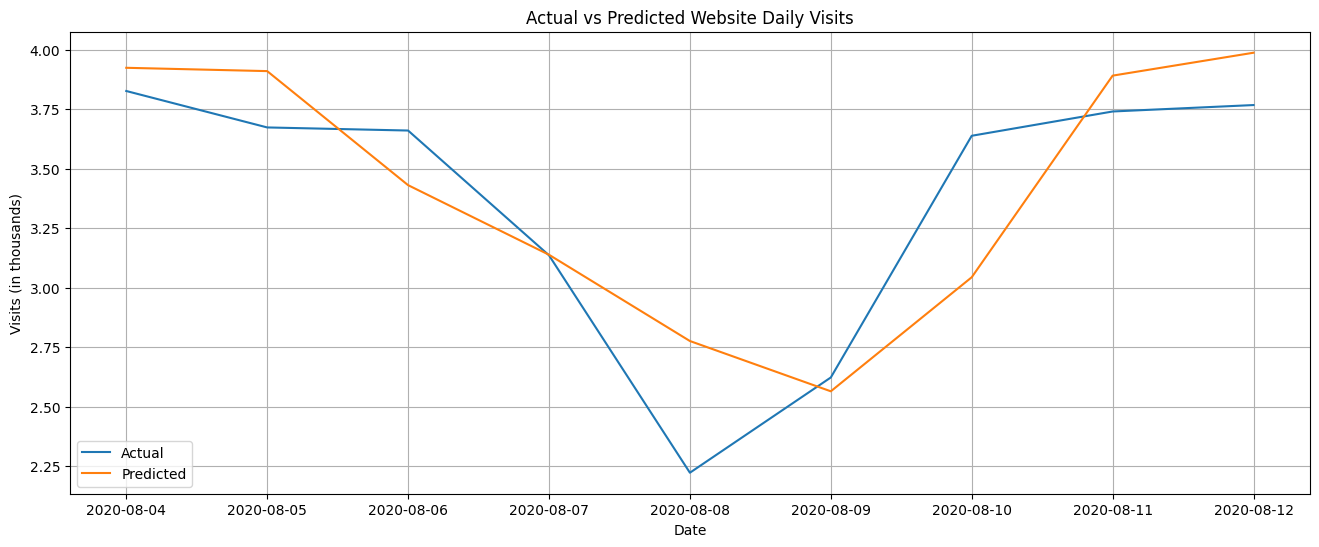

In [32]:
dates_val = df['Date'].iloc[n_steps + split:].reset_index(drop=True)

plt.figure(figsize=(16, 6))
plt.plot(dates_val, y_actual, label='Actual')
plt.plot(dates_val, y_pred, label='Predicted')
plt.title("Actual vs Predicted Website Daily Visits")
plt.xlabel("Date")
plt.ylabel("Visits (in thousands)")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [34]:
mae = mean_absolute_error(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100


In [35]:
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 0.24
MSE: 0.09
RMSE: 0.31
MAPE: 7.62%
